In [1]:
import ast
import json
import math
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import seaborn as sns
import numpy as np
from Bio import SeqIO

# Figure 4: Comparison of adaptive evolution in the receptor-binding protein of a diverse range of endemic human pathogenic viruses


Plot the estimated rates of adaptation in the polymerase (as ~control) and the receptor-binding proteins of a large range of viruses. Draw a line at ~1x10^-3 adaptive mutation per codon per year as a rough cut-off for predicted antigenic evolution

In [2]:
#calculated in Fig 2 notebook
threshold_antigenic_evo = {'bhatt': 0.96, 'kistler': 1.18}

In [3]:
#read in colors from the manuscript_colors config file
color_config_json = f'config/manuscript_colors.json'
with open(color_config_json) as json_handle:
    colors = json.load(json_handle)

In [4]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'

    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [5]:
def get_rates(virus_and_subtype, method, window, min_seqs):
    """
    Get rates of adaptation for receptor-binding protein and polymerase
    Return rates and 95CIs given in adaptive muts per codon per year x10-3
    """

    
    if 'dengue' in virus_and_subtype:
        virus = 'dengue'
        subtype = 'denv'+virus_and_subtype.split('dengue')[1]
        virus_and_subtype = 'dengue_'+subtype
    elif 'hepatitisA' in virus_and_subtype:
        virus = virus_and_subtype
        subtype=None
    else:
        if '_' in virus_and_subtype:
            virus = virus_and_subtype.split('_')[0]
            subtype = virus_and_subtype.split('_')[1]
        else:
            virus = virus_and_subtype
            subtype = None

    
    configs = readin_virus_config(virus)
    receptor_binding_gene = configs['receptor_binding']['virus_gene']
    polymerase_gene = configs['polymerase']['virus_gene']
    
    #for viruses with under 12 years of data, use smaller windows
    if virus in ['h1n1pdm', 'mumps']:
        if method=='kistler':
            window, min_seqs = 3, 3
        elif method=='bhatt':
            window, min_seqs = 3, 2

    
    #initiate dictionary, so blank will be returned if the virus/gene analysis doesn't exist
    rb_rate = {}
    if method=='bhatt':
        json_name = f'bhatt_results/bhatt_results_nextstrain_{window}_{min_seqs}/{virus_and_subtype}_{receptor_binding_gene}_bhatt_analysis_bootstrapped.json'
    elif method=='kistler':
        json_name = f'adaptation_results/results/{virus_and_subtype}_{receptor_binding_gene}_{window}_{min_seqs}_adaptation_bootstrapped.json'

    if path.exists(json_name):
        with open(json_name) as json_handle:
            json_dict = json.load(json_handle)
            (window_midpoint, adaptive_substitutions, 
             adaptive_substitutions_per_codon, 
             rate_of_adaptation, bootstrap_adaptive_substitutions, 
             bootstrap_adaptive_substitutions_per_codon, 
             bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['bootstrap_adaptive_substitutions'], 
                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                              json_dict['bootstrap_rate_of_adaptation'])

        bs_slope_sci = [x * (10**3) for x in bootstrap_rate_of_adaptation]
        lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
        upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)

        rb_rate = {'rate':rate_of_adaptation* (10**3), 'upper_95ci':upper_95ci, 
                               'lower_95ci':lower_95ci}
    #initiate dictionary, so blank will be returned if the virus/gene analysis doesn't exist
    p_rate = {}
    if method=='bhatt':
        json_name = f'bhatt_results/bhatt_results_nextstrain_{window}_{min_seqs}/{virus_and_subtype}_{polymerase_gene}_bhatt_analysis_bootstrapped.json'
    elif method=='kistler':
        json_name = f'adaptation_results/results/{virus_and_subtype}_{polymerase_gene}_{window}_{min_seqs}_adaptation_bootstrapped.json'

    if path.exists(json_name):
        with open(json_name) as json_handle:
            json_dict = json.load(json_handle)
            (window_midpoint, adaptive_substitutions, 
             adaptive_substitutions_per_codon, 
             rate_of_adaptation, bootstrap_adaptive_substitutions, 
             bootstrap_adaptive_substitutions_per_codon, 
             bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['bootstrap_adaptive_substitutions'], 
                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                              json_dict['bootstrap_rate_of_adaptation'])


        bs_slope_sci = [x * (10**3) for x in bootstrap_rate_of_adaptation]
        lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
        upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)

        p_rate = {'rate':rate_of_adaptation* (10**3), 'upper_95ci':upper_95ci, 
                  'lower_95ci':lower_95ci}
    
    return rb_rate, p_rate
    

In [6]:
def get_metadata(virus_and_subtype):
    """
    Get metadata about the virus
    """

    
    if 'dengue' in virus_and_subtype:
        virus = 'dengue'
        subtype = 'denv'+virus_and_subtype.split('dengue')[1]
#         virus_and_subtype = 'dengue_'+subtype
    elif 'hepatitisA' in virus_and_subtype:
        virus = virus_and_subtype
        subtype=None
    else:
        if '_' in virus_and_subtype:
            virus = virus_and_subtype.split('_')[0]
            subtype = virus_and_subtype.split('_')[1]
        else:
            virus = virus_and_subtype
            subtype = None
    
    #readin configs for this virus
    configs = readin_virus_config(virus)
    
    #get the human-legible name for the virus/subtype
    if subtype:
        legible_name = configs['legible_name'][subtype]
    else:
        legible_name = configs['legible_name']
    
    
    
    #get info about type of virus
    virus_family = configs['virus_family']
    genome_type = configs['genome_type']
    enveloped = configs['enveloped']
    transmission = configs['transmission']
    cellular_receptor = configs['cellular_receptor']
    fusion_protein_class = configs['fusion_protein_class']
    
    virus_family = virus_family.capitalize()
    
    #fix typo and make naming consistent
    if 'Caliciviridae' in virus_family:
        virus_family = 'Calicivirus'
    #just list virus family for rsv
    if virus_family == 'Paramyxovirus, pneumovirus':
        virus_family = 'Paramyxovirus'
                
    metadata = {'legible_name': legible_name, 'color': colors['colors'][virus_and_subtype], 
                'virus_family': virus_family,
                'color_family':colors['colors'][virus_family], 
                'color_edge_family':colors['edge_colors'][virus_family],  
                'genome_type': genome_type, 'enveloped':enveloped, 'transmission':transmission, 
                'cellular_receptor': cellular_receptor, 'fusion_protein_class':fusion_protein_class}
    return metadata

In [7]:
def get_subplot_height_ratio(viruses):
    """
    Set how tall polymerase subplot should be relative to RB plot to keep y-axis scale the same, 
    but truncate the height of the polymerase plot since the rates aren't as high
    """
    
    max_rate_p = 1.0
    min_rate_p = -0.5
    max_rate_rb = 5.5
    min_rate_rb = -0.5

    p_range = max_rate_p - min_rate_p
    rb_range = max_rate_rb - min_rate_rb
    height_ratio = [p_range/rb_range, 1]
    
    return height_ratio

In [8]:
#order viruses, within family, by rate in RB-protein
viruses = ['h3n2', 'h1n1pdm', 'vic', 'yam', 'influenzaC_Yamagata', 
           'measles', 'mumps', 'parainfluenza_1', 'parainfluenza_3','rsv_A', 'rsv_B', 
           'dengue1_V', 'dengue2_AA', 'dengue3_III', 'dengue4_II',
           'oc43_A', '229e', 'nl63',  
           'rotavirusAg1p8', 'rotavirusAg1p4', 'norovirus', 'enterovirusd68', 'hepatitisA_IA', 
           'hepatitisB_A2', 'hepatitisB_D3', 'parvovirusB19', 'adenovirusB7', 'adenovirusB3']


ordered_viruses = []

#want same family order as the list of viruses I supplied
family_order = []
virus_info = []
for virus in viruses:
    #get rates of adaptation and metadata for this virus
    rb_rate, p_rate = get_rates(virus, 'kistler', 5, 3)
    metadata = get_metadata(virus)
    #making ordered list of viral families
    if metadata['virus_family'] not in family_order:
        family_order.append(metadata['virus_family'])
    #add rate info
    if not p_rate:
        p_rate = {'rate':None}
    metadata.update({'virus':virus, 'rb_rate':rb_rate['rate'], 'p_rate':p_rate['rate']})
    virus_info.append(metadata)
    
df = pd.DataFrame(virus_info)
sort_by_rate_family = df.sort_values(['rb_rate'], ascending=False).groupby('virus_family')['virus'].apply(list)

for fam in family_order:
    sorted_within_fam = sort_by_rate_family[fam]
    ordered_viruses+=sorted_within_fam

In [35]:
def plot_rate_comparison_color_families(viruses,  method, window=5, min_seqs=3, filename=False):
    """
    Plot two panels, one showing rate of adaptation in polymerase, and one showing rate in receptor-binding protein.
    Each panel will give the rates for the specified panel of viruses
    """
    
    #find height ratio of subplots
    height_ratio = get_subplot_height_ratio(viruses)
    
    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.labelweight'] = 'normal'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['figure.dpi']= 300
    
    #initiate plot with one axis per virus
    fig, [ax_p, ax_rb] = plt.subplots(2, 1, figsize=(10,6), sharey=False, sharex=True, 
                                      gridspec_kw={'height_ratios':height_ratio})
    
    #initiate x coordinates
    xpos = 0
    #list of xtick labels
    x_labels = []
    x_ticks = []
    
    #"threshold of antigenic drift", depends on method
    threshold = threshold_antigenic_evo[method]

   #keep track of first DNA virus, to add seperator
    dna_seen = False
    rna_nonenv_seen = False
    dna_nonenv_seen = False
    
    families_seen = []

    
    for virus in viruses:
        #get rates of adaptation and metadata for this virus
        rb_rate, p_rate = get_rates(virus, method, window, min_seqs)
        metadata = get_metadata(virus)
        
        #add small space on x-axis between viral families
        if metadata['virus_family'] in families_seen:
            pass
        else:
            #increase spacing
            xpos+=0.5
            families_seen.append(metadata['virus_family'])
        
        #increase x space between RNA and DNA viruses
        #and add vertical line separating
        if 'DNA' in metadata['genome_type']:
            if dna_seen == False:
                #make double line
                ax_p.vlines(xpos+0.1, -0.25, 1.5, color='#d3d3d3', linewidth=2)
                ax_p.vlines(xpos-0.1, -0.25, 1.5, color='#d3d3d3', linewidth=2)
                ax_rb.vlines(xpos+0.1, -0.25, 7, color='#d3d3d3', linewidth=2)
                ax_rb.vlines(xpos-0.1, -0.25, 7, color='#d3d3d3', linewidth=2)
                ax_rb.text(xpos-0.3, 6.8, 'RNA', color='#808080', fontsize=14, 
                           horizontalalignment='right', verticalalignment='top', rotation=90)
                ax_rb.text(xpos+0.3, 6.8, 'DNA', color='#808080', fontsize=14, 
                           horizontalalignment='left', verticalalignment='top', rotation=90)
                xpos+=1
            dna_seen = True
            
        #make divider for enveloped too
        if dna_seen == False and metadata['enveloped']=='False':
            if rna_nonenv_seen == False:
                ax_p.vlines(xpos, -0.25, 1.5, color='#d3d3d3', linewidth=2)
                ax_rb.vlines(xpos, -0.25, 7, color='#d3d3d3', linewidth=2)
                ax_rb.text(xpos-0.3, 6.8, 'Enveloped', color='#808080', fontsize=11, 
                           horizontalalignment='right', verticalalignment='top', rotation=90)
                ax_rb.text(xpos+0.3, 6.8, 'Non-env', color='#808080', fontsize=11, 
                           horizontalalignment='left', verticalalignment='top', rotation=90)
                xpos+=1
            rna_nonenv_seen = True
        #and DNA enveloped divided    
        if 'DNA' in metadata['genome_type'] and metadata['enveloped']=='False':
            if dna_nonenv_seen == False:
                ax_p.vlines(xpos, -0.25, 1.5, color='#d3d3d3', linewidth=2)
                ax_rb.vlines(xpos, -0.25, 7, color='#d3d3d3', linewidth=2)
                ax_rb.text(xpos-0.3, 6.8, 'Enveloped', color='#808080', fontsize=11, 
                           horizontalalignment='right', verticalalignment='top', rotation=90)
                ax_rb.text(xpos+0.3, 6.8, 'Non-env', color='#808080', fontsize=11, 
                           horizontalalignment='left', verticalalignment='top', rotation=90)
                xpos+=1
            dna_nonenv_seen = True

            
        #because parvovirus doesn't have a polymerase
        if len(p_rate)!=0:  
            ax_p.vlines(xpos, p_rate['lower_95ci'], p_rate['upper_95ci'], color=metadata['color_edge_family'], linewidth=1.0)

            #filled or open circle depending on whether rate is over threshold
            if p_rate['rate']>= threshold:
                ax_p.plot(xpos, p_rate['rate'], 'o', ms=12, color=metadata['color_family'], 
                          markeredgewidth=1.5, markeredgecolor=metadata['color_edge_family'])
            else:
                ax_p.plot(xpos, p_rate['rate'], 'o', ms=12, color='white', 
                          markeredgewidth=1.5, markeredgecolor=metadata['color_edge_family'])
            
        #plot RB rate
        ax_rb.vlines(xpos, rb_rate['lower_95ci'], rb_rate['upper_95ci'], color=metadata['color_edge_family'], linewidth=1.0)
        #filled or open circle depending on whether rate is over threshold 
        if rb_rate['rate']>= threshold:
            ax_rb.plot(xpos, rb_rate['rate'], 'o', ms=12, color=metadata['color_family'], 
                       markeredgewidth=1.5, markeredgecolor=metadata['color_edge_family'])
        else:
            ax_rb.plot(xpos, rb_rate['rate'], 'o', ms=12, color='white', 
                       markeredgewidth=1.5, markeredgecolor=metadata['color_edge_family'])
        
        x_ticks.append(xpos)
        x_labels.append(metadata['legible_name'])
        #increase x coodinate for next virus
        xpos+=1
        
    #label the gene that is being plotted in the subplots
    ax_p.text(0.02, 1.0, 'Polymerase', horizontalalignment='left', 
               verticalalignment='center', fontsize=14, transform=ax_p.transAxes)
    ax_rb.text(0.02, 1.0, 'Receptor-Binding Protein', horizontalalignment='left', 
               verticalalignment='center', fontsize=14, transform=ax_rb.transAxes)
    
    #make axes have consistent scales
    lower_bound, upper_bound = ax_rb.get_ylim()
    ax_p.set_ylim(lower_bound, upper_bound*height_ratio[0])
    
    #label viruses along x-axis
    ax_rb.set_xticks(x_ticks)
    ax_rb.set_xticklabels(x_labels, rotation=90)
    
    #set y-axis label
    ax_rb.set_ylabel('Adaptive Muts per Codon per Year $(× 10^{-3})$')
    ax_rb.yaxis.set_label_coords(-0.04, 0.7)
    
    
    #add a horizontal line at threshold for antigenic drift
    ax_rb.axhline(threshold, color='#808080', linestyle='dashed', zorder=1)
    ax_p.axhline(threshold, color='#808080', linestyle='dashed', zorder=1)
    
    #add a legend
    handles = []
    leg_text = []
    for fam in ["Orthomyxovirus", "Paramyxovirus", "Flavivirus", "Coronavirus", "Reovirus", 
                "Calicivirus", "Picornavirus", "Hepadnavirus", "Parvovirus", "Adenovirus"]:
        handles.append(Line2D([], [], color='white', marker='o', 
                              markerfacecolor=colors['colors'][fam], 
                              markeredgecolor=colors['edge_colors'][fam], markersize=8))
        leg_text.append(fam)
        
    leg = ax_rb.legend(handles, leg_text,
                      bbox_to_anchor=(1.15, 1.1), frameon=True, labelspacing = 1.0, borderpad=1, 
                       title= "Viral Family",title_fontproperties={'weight':'bold'})
    
    plt.subplots_adjust(hspace=0.2)
    
    sns.despine()
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
    

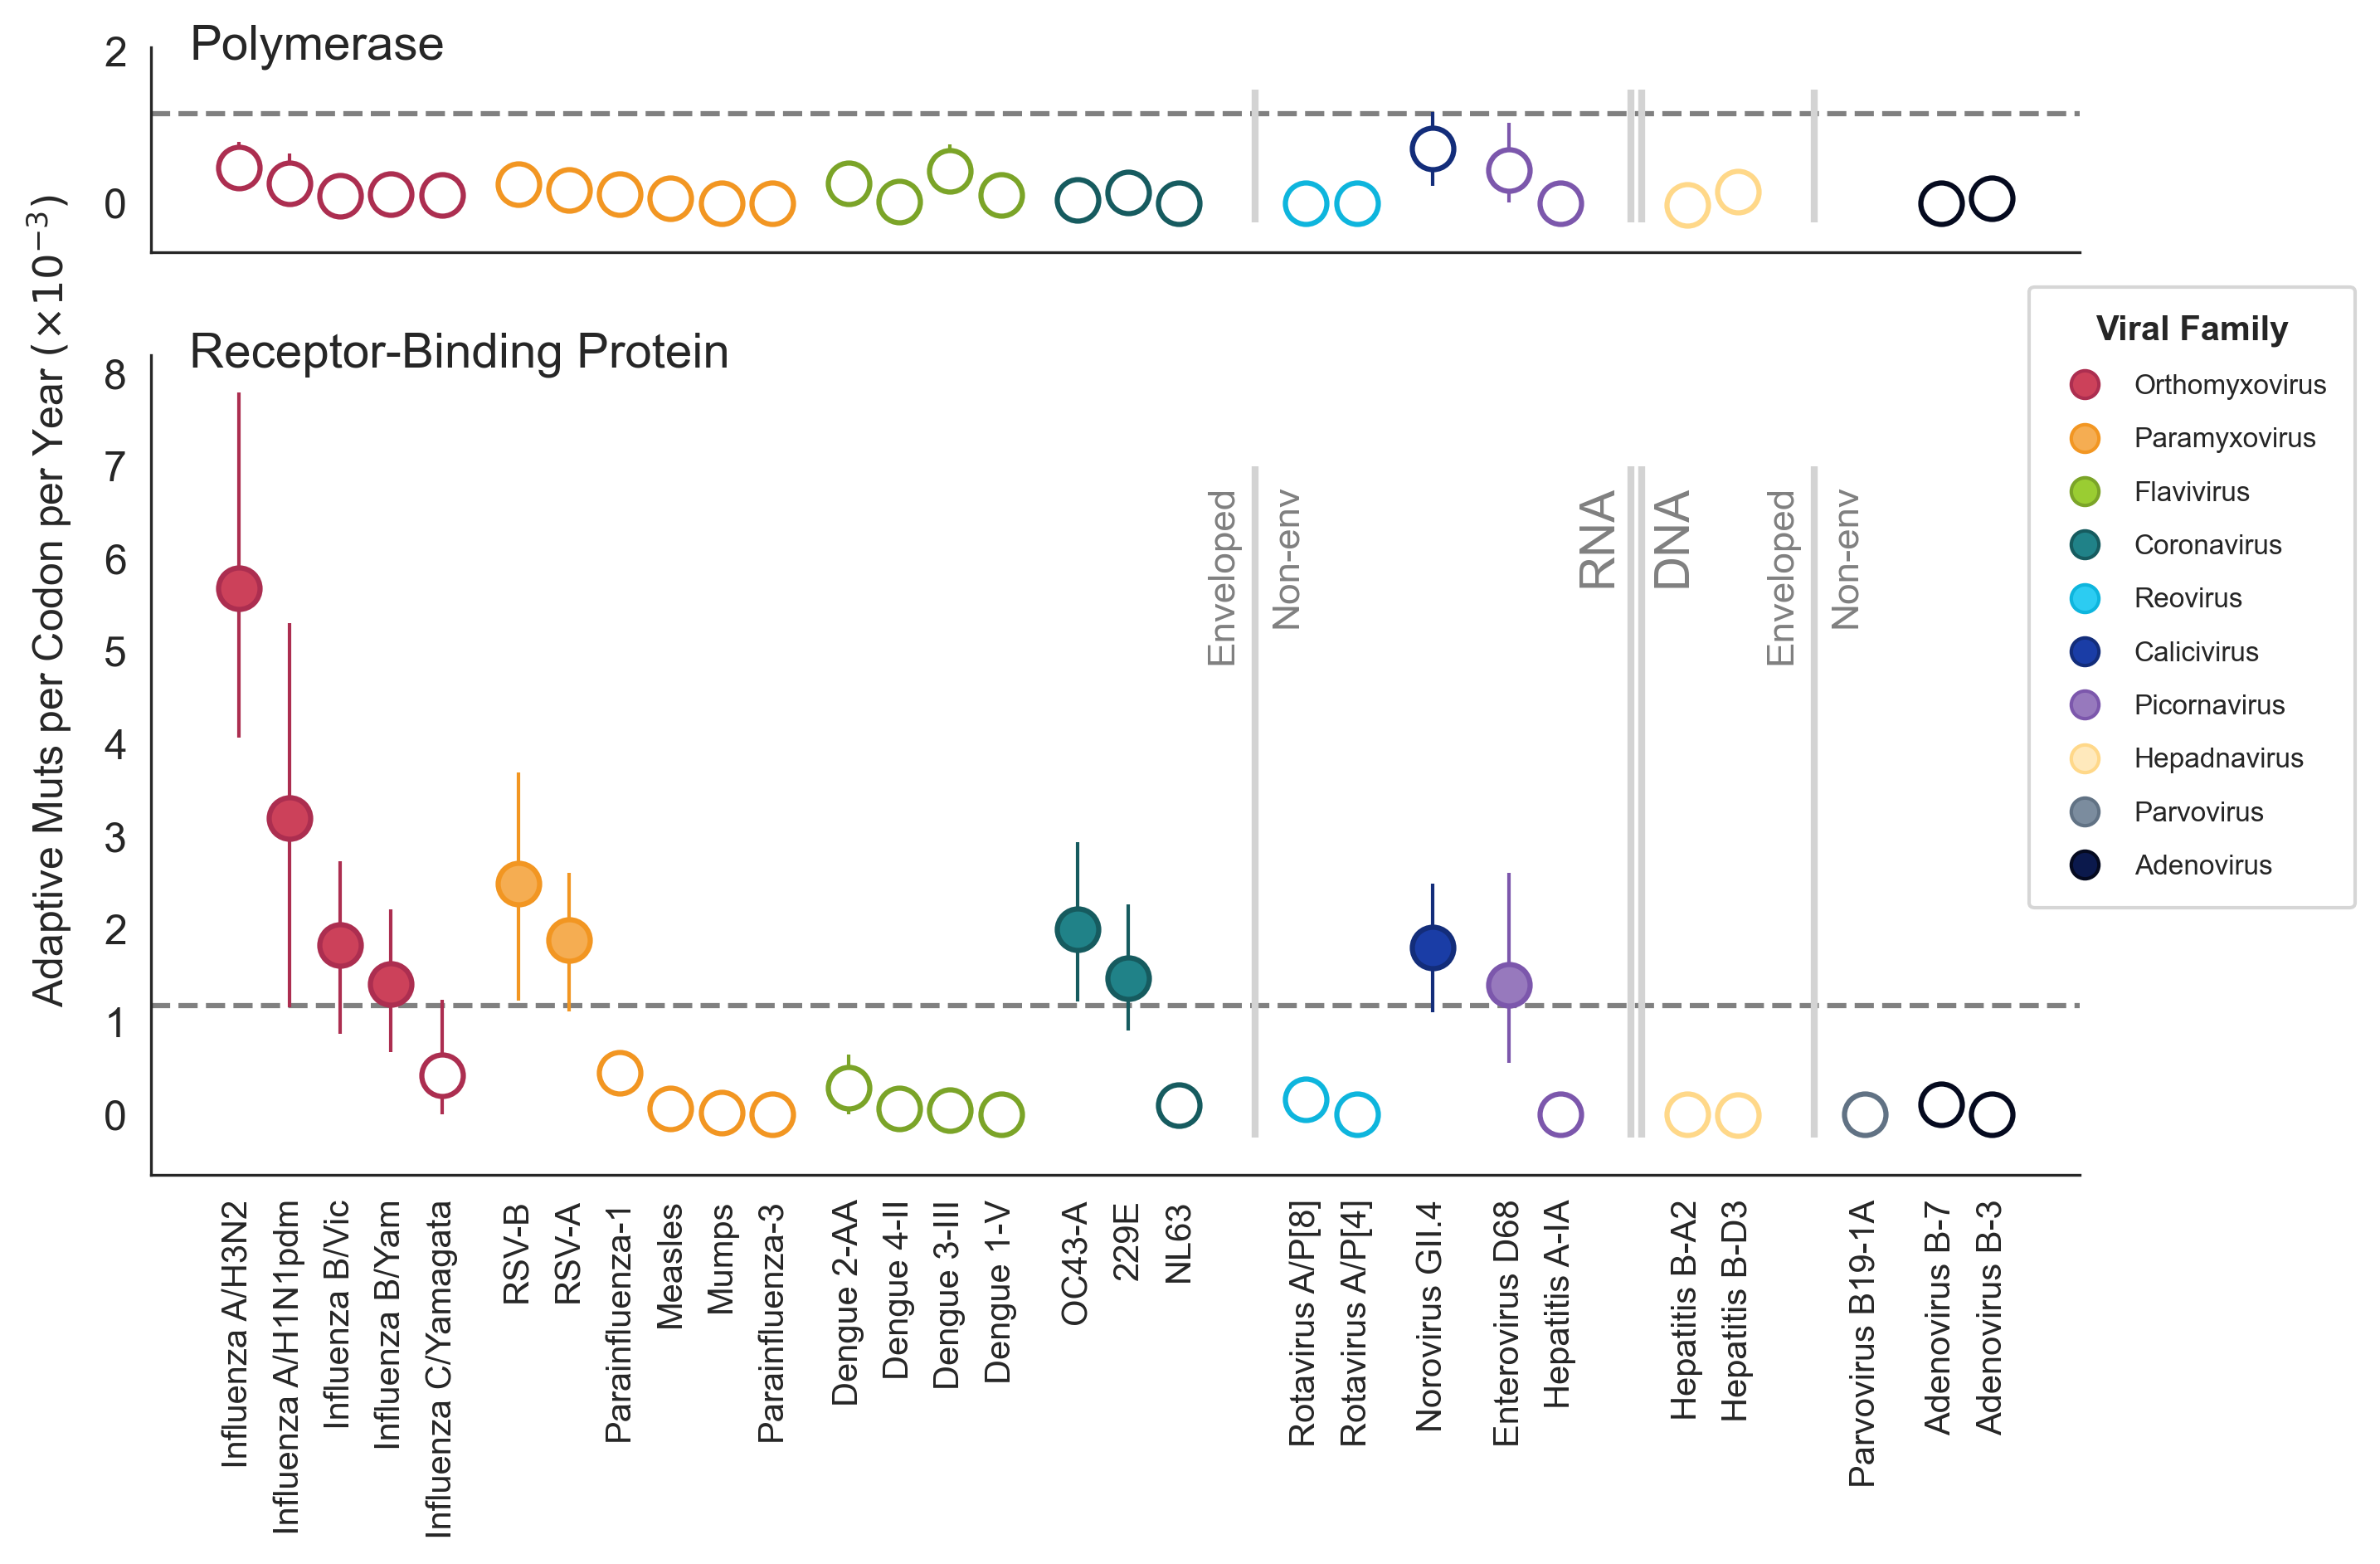

In [37]:
plot_rate_comparison_color_families(ordered_viruses, 
                        method='kistler')

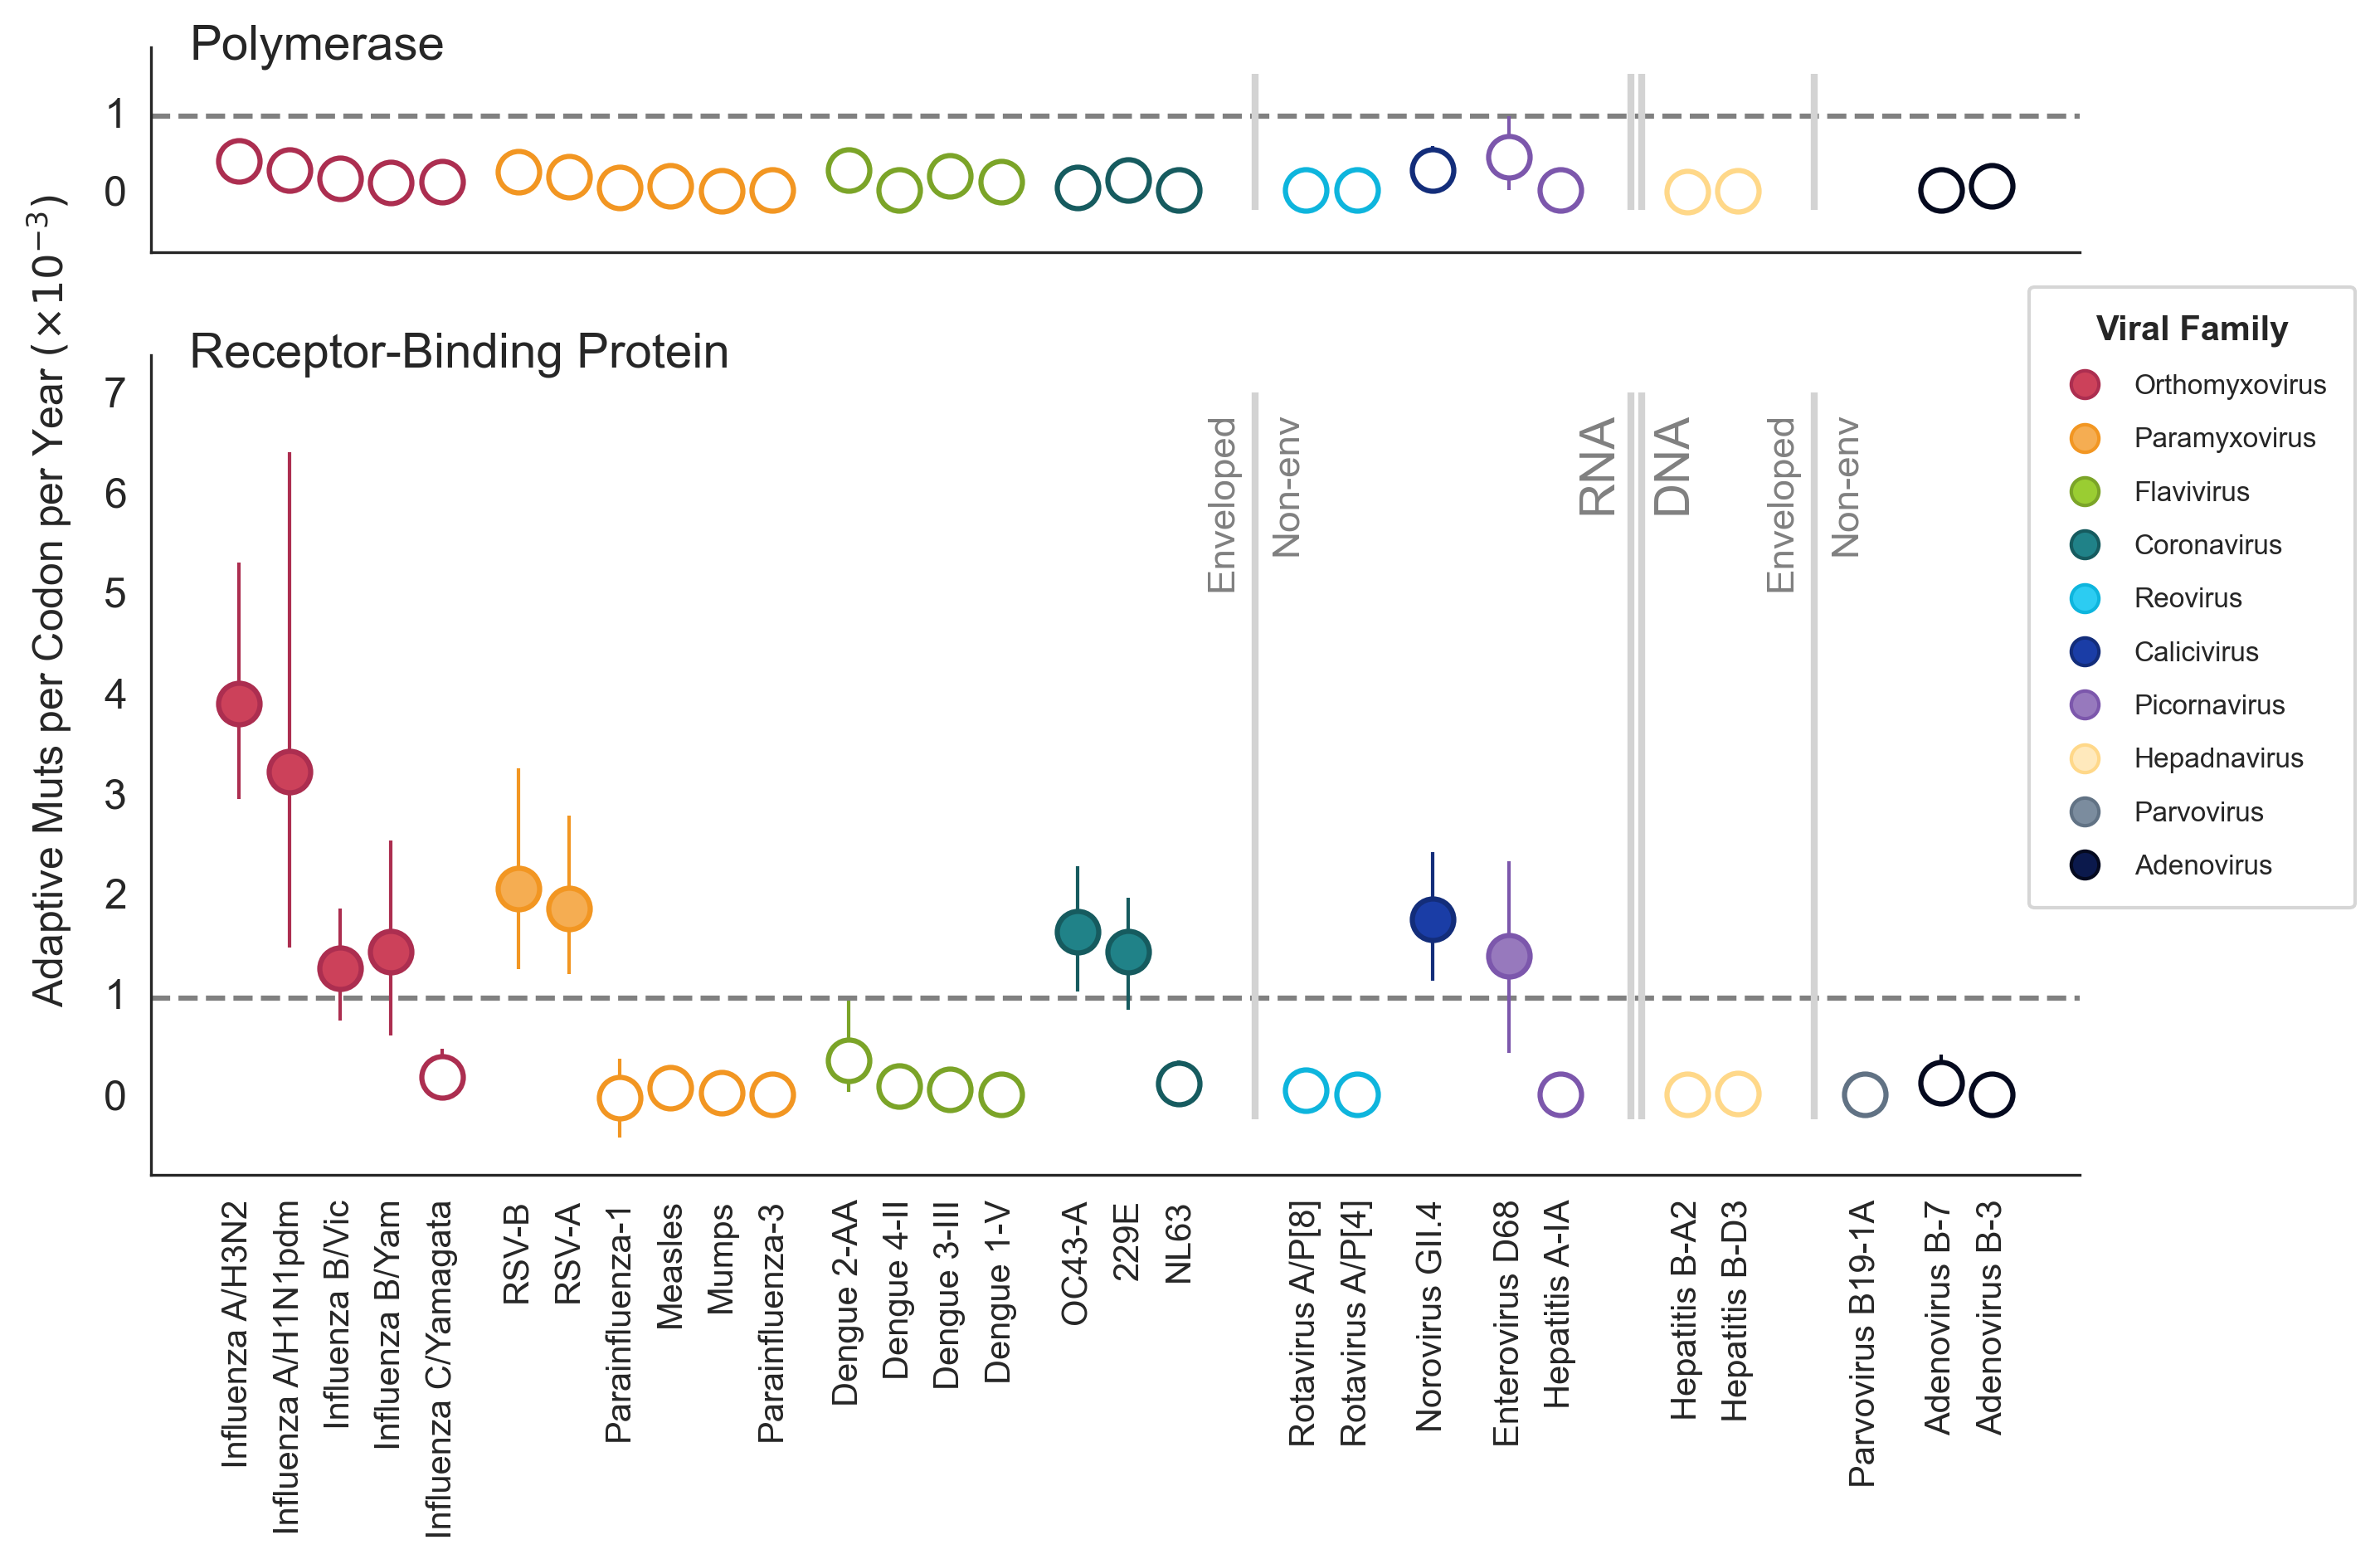

In [38]:
plot_rate_comparison_color_families(ordered_viruses, 
                        method='bhatt', filename = 'manuscript_figures/Figure4_AntigenicPanelBhatt.png')